In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, AveragePooling2D, concatenate
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from keras.utils import np_utils

width = 32
height = 32

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3

In [2]:
num_classes = 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [3]:
validation_images, validation_labels = x_train[:500], y_train[:500]
train_images, train_labels = x_train[500:], y_train[500:]

In [4]:
train_images.shape

(49500, 32, 32, 3)

In [5]:
def inception(x, filters): 
    pre_layer = x
    
    f1,f2,f3,f4 = filters #filter 수의 숫자

    # 1x1
    conv1 = Conv2D(f1, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)  #f1=64
    
    # 1x1 & 3x3  (functional API)
    conv2 = Conv2D(f4  , kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(f2, kernel_size=(3,3), padding='same', activation='relu')(conv2)  #f2=128

    # 1x1 & 5x5
    conv3 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv3 = Conv2D(f3, kernel_size=(5,5), padding='same', activation='relu')(conv3)  #f3=32
    
    # pooling & 1x1
    max_pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre_layer)
    max_pool = Conv2D(f4, kernel_size=(1,1), padding='same')(max_pool)

    # output = [None(batch_size), w(width),h(height),c(channel)], c 기준 concatenate (axis = -1 )
    # concatenate() >>  적층, axis=-1 >> channel 기준으로 적층하겠다는 의미 
    
    concat = concatenate([conv1, conv2, conv3, max_pool], axis=-1)
    
    return concat
    

In [6]:
input_shape = x_train[0].shape    
inputs = Input(shape=input_shape)

# conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x) 

#inception (input, [#1x1conv, #3x3conv, #5x5conv, #1x1reduction] )


# inception 3a
x = inception(x,[64,128,32,32])
# inception 3b
x = inception(x,[128,192,96,64])
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# inception 4a
x = inception(x,[192,208,48,64])
aux1 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux1 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux1)
aux1 = Flatten()(aux1)
aux1 = Dense(512, activation='relu')(aux1)  #512개 vector 
aux1 = Dense(10, activation='softmax')(aux1) #cifar 10 data 10개 분류 

# inception 4b
x = inception(x,[160,224,64,64])


# inception 4c
x = inception(x,[128,256,64,64])
# inception 4d
x = inception(x,[112,288,64,64])
aux2 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux2 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux2)
aux2 = Flatten()(aux2)
aux2 = Dense(832, activation='relu')(aux2)
aux2 = Dense(10, activation='softmax')(aux2)


# inception 4e
x = inception(x,[256,320,128,128])


# inception 5a
x = inception(x,[256,320,128,128])
# inception 5b
x = inception(x,[384,384,128,128])
x = AveragePooling2D(pool_size=(4,4), padding='valid')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

outputs = Dense(10, activation='softmax')(x)



In [7]:
model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer='adam', loss='categorical_crossentropy', loss_weights=[0.3,0.3,1.0], metrics=['accuracy']) 


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 192)  110784      batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
history = model.fit_generator(train_datagen.flow(train_images,train_labels, batch_size = 32), 
                    validation_data = validation_datagen.flow(validation_images, validation_labels, batch_size = 32),
                    epochs = 10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1547/1547 [==============================] - 99s 40ms/step - loss: 2.8916 - dense_1_loss: 1.7419 - dense_3_loss: 1.7868 - dense_4_loss: 1.8330 - dense_1_accuracy: 0.3544 - dense_3_accuracy: 0.3348 - dense_4_accuracy: 0.3237 - val_loss: 2.1078 - val_dense_1_loss: 1.3160 - val_dense_3_loss: 1.3203 - val_dense_4_loss: 1.3169 - val_dense_1_accuracy: 0.5200 - val_dense_3_accuracy: 0.5200 - val_dense_4_accuracy: 0.5080
Epoch 2/10
1547/1547 [==============================] - 61s 39ms/step - loss: 2.0492 - dense_1_loss: 1.2315 - dense_3_loss: 1.2688 - dense_4_loss: 1.2991 - dense_1_accuracy: 0.5588 - dense_3_accuracy: 0.5429 - dense_4_accuracy: 0.5338 - val_loss: 1.8805 - val_dense_1_loss: 1.1779 - val_dense_3_loss: 1.1649 - val_dense_4_loss: 1.1777 - val_dense_1_accuracy: 0.5920 - val_dense_3_accuracy: 0.5920 - val_dense_4_accuracy: 0.5800
Epoch 3/10
1547/1547 [==============================] - 60s 39ms/step - loss: 1.6685 - dense_1_loss: 1.0102 - dense_3_loss: 1.0240 - dense_4_los

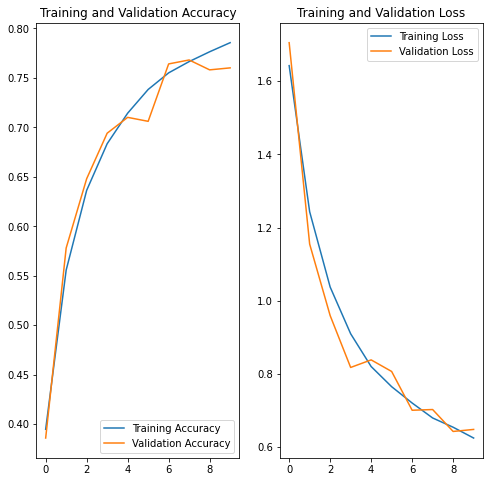

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['dense_4_accuracy']
val_acc = history.history['val_dense_4_accuracy']

loss = history.history['dense_4_loss']
val_loss = history.history['val_dense_4_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('googLeNet.h5')